In [4]:
!pip install scikit-learn
!pip install scikit-optimize
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.9 MB/s eta 0:00:00


Iteration No: 1 started. Evaluating function at random point.
Iteration 1: Accuracy = 0.8551, Features = ['Glycine - G', 'Leucine - L', 'Methionine - M', 'Serine - S', 'Valine - V', 'Isoleucine - I', 'Tyrosine - Y', 'Histidine - H', 'Arginine - R', 'Threonine - T', 'Charged', 'Uncharged', 'Drug Score', 'Small', 'Aromatic']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.6767
Function value obtained: -0.8551
Current minimum: -0.8551
Iteration No: 2 started. Evaluating function at random point.
Iteration 2: Accuracy = 0.8261, Features = ['Glycine - G', 'Leucine - L', 'Methionine - M', 'Lysine - K', 'Glutamine - Q', 'Isoleucine - I', 'Cysteine - C', 'Tyrosine - Y', 'Aspartic Acid - D', 'Charged', 'Uncharged', 'Number of apolar alpha sphere', 'Pocket volume (convex hull)', 'Number of residues']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.4490
Function value obtained: -0.8261
Current minimum: -0.8551
Iteration No: 3 started. Evaluating functi

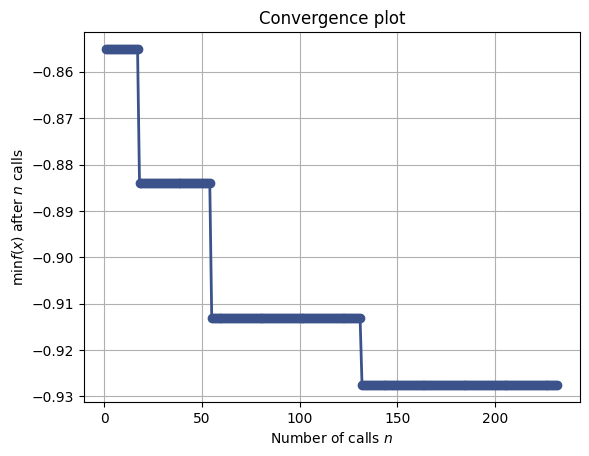

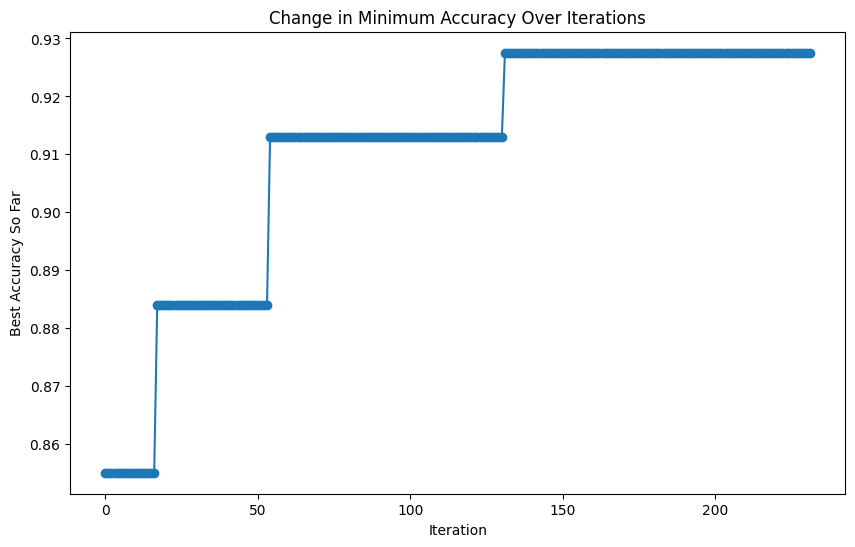

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from skopt import gp_minimize
from skopt.space import Categorical
from xgboost import XGBClassifier
from skopt.plots import plot_convergence
import heapq  # For finding the top 10 feature combinations
import csv  # For saving iteration results

# Load the dataset
file_path = 'TestTrain.csv'  # Local file path provided
data = pd.read_csv(file_path)

# Dropping the first column if it's an index or identifier
data_clean = data.drop(columns=['Protein'])

# Define feature groups and subgroups (convert tuples to strings)
feature_groups = [
    ['Exclude', 'Glycine - G'],
    ['Exclude', 'Alanine - A'],
    ['Exclude', 'Leucine - L'],
    ['Exclude', 'Methionine - M'],
    ['Exclude', 'Phenylalanine - F'],
    ['Exclude', 'Tryptophan - W'],
    ['Exclude', 'Lysine - K'],
    ['Exclude', 'Glutamine - Q'],
    ['Exclude', 'Glutamic Acid - E'],
    ['Exclude', 'Serine - S'],
    ['Exclude', 'Proline - P'],
    ['Exclude', 'Valine - V'],
    ['Exclude', 'Isoleucine - I'],
    ['Exclude', 'Cysteine - C'],
    ['Exclude', 'Tyrosine - Y'],
    ['Exclude', 'Histidine - H'],
    ['Exclude', 'Arginine - R'],
    ['Exclude', 'Asparagine - N'],
    ['Exclude', 'Aspartic Acid - D'],
    ['Exclude', 'Threonine - T'],
    ['Exclude', 'Charged | Uncharged', 'Charge Score', 'Positive charge | Negative charge', 'Pos-neg charge ratio'],
    ['Exclude', 'Polar | Non-polar', 'Polarity Score', 'Hydrophobicity Score', 'Local hydrophobic density Score',
     'Number of apolar alpha sphere', 'Proportion of apolar alpha sphere', 'Hydrophobic', 'Mean alpha-sphere Solvent Acc.'],
    ['Exclude', 'Drug Score'],
    ['Exclude', 'Small', 'Number of alpha spheres | Mean alpha-sphere radius', 'Pocket volume (Monte Carlo)', 'Pocket volume (convex hull)'],
    ['Exclude', 'Amino Acid based volume Score'],
    ['Exclude', 'Aromatic'],
    ['Exclude', 'Number of residues']
]

# Mapping of string representations back to tuples
string_to_tuple = {
    'Charged | Uncharged': ('Charged', 'Uncharged'),
    'Positive charge | Negative charge': ('Positive charge', 'Negative charge'),
    'Polar | Non-polar': ('Polar', 'Non-polar'),
    'Number of alpha spheres | Mean alpha-sphere radius': ('Number of alpha spheres', 'Mean alpha-sphere radius')
}

# Prepare target variable
y = data_clean['Cyclical']

# Initialize leave-one-out cross-validator
loo = LeaveOneOut()

# Function to perform Leave-One-Out Cross-Validation for a given set of features
def loo_cv(X, y, sample_weights):
    correct_predictions = 0
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        sample_weights_train = sample_weights.iloc[train_index]

        # Initialize and fit the XGBoost model with GPU support
        model = XGBClassifier(
            eval_metric='logloss',
            reg_alpha=0.1,
            reg_lambda=1.0,
            verbosity=0,
            random_state=42,
            use_label_encoder=False,
            tree_method='hist',  # Use histogram-based method
            device='cuda',  # Set the device to 'cuda' to use GPU
            learning_rate=0.1
        )

        model.fit(X_train, y_train, sample_weight=sample_weights_train, verbose=False)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        if y_pred[0] == y_test.values[0]:
            correct_predictions += 1

    # Calculate and return average accuracy
    return correct_predictions / len(y)

# Calculate class weights
class_weights = y.value_counts(normalize=True).to_dict()
weight_map = {k: 1/v for k, v in class_weights.items()}
sample_weights = y.map(weight_map)

# Track all combinations and their accuracies
all_results = []
minimum_accuracies = []  # To track how the minimum changes over iterations
iteration_counter = 0  # To track iteration numbers

# Define the Bayesian optimization objective function
def objective(feature_combination):
    global iteration_counter
    iteration_counter += 1  # Increment iteration count

    selected_features = []

    # Add selected subgroups from feature groups
    for i, subgroup in enumerate(feature_combination):
        if subgroup != 'Exclude':  # Include only selected subgroups
            # Map string back to tuple if applicable
            if subgroup in string_to_tuple:
                selected_features.extend(string_to_tuple[subgroup])
            else:
                selected_features.append(subgroup)

    if not selected_features:  # No features selected
        print(f"Iteration {iteration_counter}: No features selected. Skipping.")
        return 1.0  # Worst possible score

    X_new = data_clean[selected_features]  # Subset dataset
    avg_accuracy = loo_cv(X_new, y, sample_weights)  # Evaluate accuracy

    # Log the feature combination and its accuracy
    print(f"Iteration {iteration_counter}: Accuracy = {avg_accuracy:.4f}, Features = {selected_features}")
    all_results.append((avg_accuracy, selected_features))

    # Save the current iteration's details to a CSV file
    with open('feature_combination_log.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        if iteration_counter == 1:  # Write header only for the first iteration
            writer.writerow(['Iteration', 'Accuracy', 'Selected Features'])
        writer.writerow([iteration_counter, avg_accuracy, selected_features])

    # Update the running minimum accuracy
    if minimum_accuracies:
        minimum_accuracies.append(max(minimum_accuracies[-1], avg_accuracy))
    else:
        minimum_accuracies.append(avg_accuracy)

    return -avg_accuracy  # Return negative accuracy for minimization

# Define the search space: one categorical variable per feature group
search_space = [Categorical(group, name=f'group_{i}') for i, group in enumerate(feature_groups)]

# Parameters for early stopping
patience = 100  # Number of iterations with no significant improvement
tolerance = 1e-4  # Minimum improvement considered significant

# Callback for early stopping
validation_scores = []  # To track objective function values (negative accuracy)

def early_stopping_callback(res):
    validation_scores.append(-res.fun)  # Store the negative objective function (accuracy)

    # Check if we have enough iterations to evaluate stopping
    if len(validation_scores) > patience:
        # Calculate the improvement in the last `patience` iterations
        recent_improvements = [
            abs(validation_scores[-(i + 1)] - validation_scores[-i])
            for i in range(1, patience + 1)
        ]
        # Stop if all improvements are below the tolerance
        if all(imp < tolerance for imp in recent_improvements):
            print(f"Early stopping criterion met at iteration {len(validation_scores)}.")
            return True  # Signal to stop optimization
    return False

# Perform Bayesian Optimization with early stopping
gp_result = gp_minimize(
    func=objective,  # Objective function
    dimensions=search_space,  # Search space
    n_calls=500,  # Maximum number of evaluations
    random_state=42,  # Reproducibility
    verbose=True,  # Verbose output
    acq_func="LCB",  # Use Lower Confidence Bound
    kappa=10.0,  # Higher kappa for more exploration
    callback=[early_stopping_callback]  # Early stopping callback
)

# Extract the best feature combination
best_combination = gp_result.x
selected_features = []

# Extract the top 10 feature combinations
top_combinations = heapq.nlargest(10, all_results, key=lambda x: x[0])  # Sort by accuracy (first element of tuple)

# Print the top 10 combinations
print("\nTop 10 Feature Combinations:")
for rank, (accuracy, features) in enumerate(top_combinations, start=1):
    print(f"{rank}. Accuracy: {accuracy:.4f}, Features: {features}")

for i, subgroup in enumerate(best_combination):
    if subgroup != 'Exclude':
        if subgroup in string_to_tuple:
            selected_features.extend(string_to_tuple[subgroup])
        else:
            selected_features.append(subgroup)

# Print the best feature combination and its accuracy
print("\nBest feature combination:", selected_features)
print("Best accuracy:", -gp_result.fun)

# Plot convergence of Bayesian Optimization
plot_convergence(gp_result)
plt.show()

# Plot how the minimum accuracy changes over iterations
plt.figure(figsize=(10, 6))
plt.plot(minimum_accuracies, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Best Accuracy So Far')
plt.title('Change in Minimum Accuracy Over Iterations')
plt.show()
